In [8]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
import tflearn

from tf_RBM import RBM
from tf_RBM import showConfusionMatrix
from tf_RBM import oneHotEncoder

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train_img = mnist.train.images
train_label = mnist.train.labels

test_img = mnist.test.images
test_label = mnist.test.labels

# get the label in single number case
train_true_label = np.argmax(train_label, axis=1)
test_true_label = np.argmax(test_label, axis=1)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Classification using the raw-pixel data

Training Step: 8600  | total loss: 0.35363
| Adam | epoch: 010 | loss: 0.35363 -- iter: 55000/55000
Training Step: 8600  | total loss: 0.35363
| Adam | epoch: 010 | loss: 0.35363 -- iter: 55000/55000
--
Training Accuract: 0.92962
Testing Accuract: 0.9266


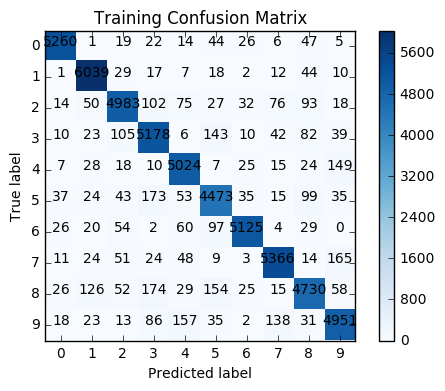

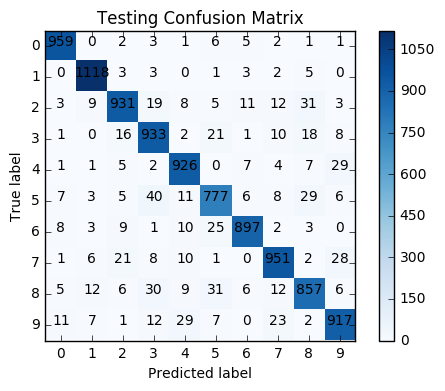

In [9]:
# Classification using tflearn
with tf.Graph().as_default():
    tflearn.init_graph(num_cores=4, gpu_memory_fraction=0.5)

    # build the one-layer fully connected neural network
    net = tflearn.input_data(shape=[None, 784])
    net = tflearn.fully_connected(net, 10, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

    # fit the model
    model = tflearn.DNN(net)
    model.fit(train_img, train_label)

    # predict on the training and test dataset
    train_prediction = np.array(model.predict(train_img))
    test_prediction = np.array(model.predict(test_img))

# get the label
train_pred_label = np.argmax(train_prediction, axis=1)
test_pred_label = np.argmax(test_prediction, axis=1)

# calculate the training and testing accuracy
train_acc = np.sum(train_pred_label == train_true_label) / len(train_true_label)
test_acc = np.sum(test_pred_label == test_true_label) / len(test_true_label)
print('Training Accuract:', str(np.round(train_acc, 5)))
print('Testing Accuract:', str(np.round(test_acc, 5)))

# calculate the confusion matrix
trainMatrix = np.dot(train_label.T, oneHotEncoder(np.array([train_pred_label]).T, 10))
testMatrix = np.dot(test_label.T, oneHotEncoder(np.array([test_pred_label]).T, 10))

# plot the training and test confusion matrix
label=[str(i) for i in range(10)]
title1 = 'Training Confusion Matrix'
fig1 = showConfusionMatrix(trainMatrix.astype(int), title=title1, label=label, fontsize=10)
fig1.savefig('./result/train_raw.pdf')
plt.show()

title2 = 'Testing Confusion Matrix'
fig2 = showConfusionMatrix(testMatrix.astype(int), title=title2, label=label, fontsize=10)
fig2.savefig('./result/test_raw.pdf')
plt.show()

# Classification using single layer RBM

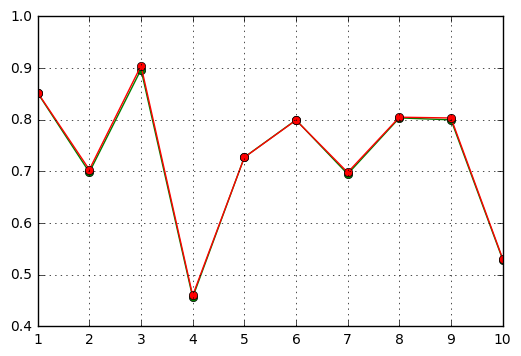

In [38]:
# test case, only used to determine the tuned parameters
train_acc_list = []
test_acc_list = []
for n in range(1, 11):
    # build the RBM model
    model = RBM(visible_nodes=784, hidden_nodes=200, learning_rate=0.1, batch_size=10, n_iter=n)
    W, b, c = model.train(train_img)

    # calculate the output of RBM on training and testing dataset
    train_rbm = 1 / (1 + np.exp(-np.dot(train_img, W.T) + c))
    test_rbm = 1 / (1 + np.exp(-np.dot(test_img, W.T) + c))

    # Classification using tflearn
    with tf.Graph().as_default():
        tflearn.init_graph(num_cores=6, gpu_memory_fraction=0.8)

        # build the one-layer fully connected neural network
        net = tflearn.input_data(shape=[None, 200])
        net = tflearn.fully_connected(net, 10, activation='softmax')
        net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

        # fit the model
        model = tflearn.DNN(net)
        model.fit(train_rbm, train_label)

        # predict on the training and test dataset
        train_prediction = np.array(model.predict(train_rbm))
        test_prediction = np.array(model.predict(test_rbm))

    # get the label
    train_pred_label = np.argmax(train_prediction, axis=1)
    test_pred_label = np.argmax(test_prediction, axis=1)

    # calculate the training and testing accuracy
    train_acc = np.sum(train_pred_label == train_true_label) / len(train_true_label)
    test_acc = np.sum(test_pred_label == test_true_label) / len(test_true_label)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

# plot the train and test accuracy
fig, ax = plt.subplots()
ax.plot(range(1, len(train_acc_list)+1), train_acc_list, 'go-')
ax.plot(range(1, len(train_acc_list)+1), test_acc_list, 'ro-')
ax.grid()
plt.show()

Training Step: 8600  | total loss: 0.88822
| Adam | epoch: 010 | loss: 0.88822 -- iter: 55000/55000
Training Step: 8600  | total loss: 0.88822
| Adam | epoch: 010 | loss: 0.88822 -- iter: 55000/55000
--
Training Accuract: 0.84371
Testing Accuract: 0.8511


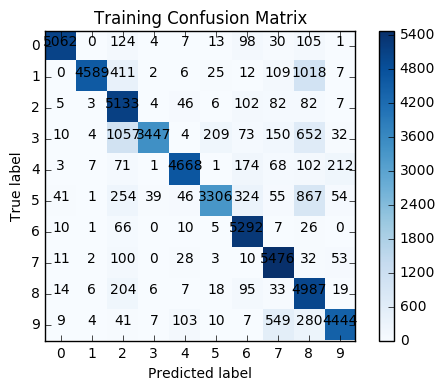

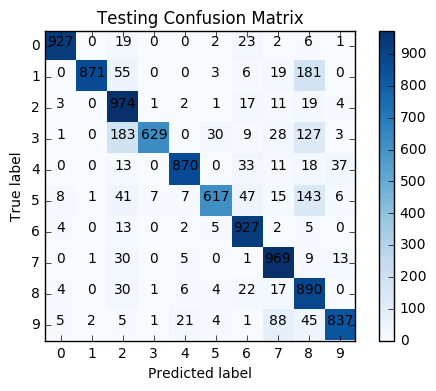

In [39]:
# build the RBM model
model = RBM(visible_nodes=784, hidden_nodes=200, learning_rate=0.1, batch_size=10, n_iter=3)
W, b, c = model.train(train_img)

# calculate the output of RBM on training and testing dataset
train_rbm = 1 / (1 + np.exp(-np.dot(train_img, W.T) + c))
test_rbm = 1 / (1 + np.exp(-np.dot(test_img, W.T) + c))

# Classification using tflearn
with tf.Graph().as_default():
    tflearn.init_graph(num_cores=6, gpu_memory_fraction=0.6)

    # build the one-layer fully connected neural network
    net = tflearn.input_data(shape=[None, 200])
    net = tflearn.fully_connected(net, 10, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

    # fit the model
    model = tflearn.DNN(net)
    model.fit(train_rbm, train_label)

    # predict on the training and test dataset
    train_prediction = np.array(model.predict(train_rbm))
    test_prediction = np.array(model.predict(test_rbm))

# get the label
train_pred_label = np.argmax(train_prediction, axis=1)
test_pred_label = np.argmax(test_prediction, axis=1)

# calculate the training and testing accuracy
train_acc = np.sum(train_pred_label == train_true_label) / len(train_true_label)
test_acc = np.sum(test_pred_label == test_true_label) / len(test_true_label)
print('Training Accuract:', str(np.round(train_acc, 5)))
print('Testing Accuract:', str(np.round(test_acc, 5)))

# calculate the confusion matrix
trainMatrix = np.dot(train_label.T, oneHotEncoder(np.array([train_pred_label]).T, 10))
testMatrix = np.dot(test_label.T, oneHotEncoder(np.array([test_pred_label]).T, 10))

# plot the training and test confusion matrix
label=[str(i) for i in range(10)]
title1 = 'Training Confusion Matrix'
fig1 = showConfusionMatrix(trainMatrix.astype(int), title=title1, label=label, fontsize=10)
fig1.savefig('./result/train_rbm.pdf')
plt.show()

title2 = 'Testing Confusion Matrix'
fig2 = showConfusionMatrix(testMatrix.astype(int), title=title2, label=label, fontsize=10)
fig2.savefig('./result/test_rbm.pdf')
plt.show()

In [41]:
# # visualize the learned weights
# imgs = np.reshape(W[:200, :], (200, 28, 28))
# fig, ax = plt.subplots(nrows=8, ncols=8)
# for i in range(8):
#     for j in range(8):
#         ax[i, j].imshow(imgs[i * 8 + j, :, :], cmap=plt.cm.gray_r, interpolation='none')
#         ax[i, j].set_xticks([])
#         ax[i, j].set_yticks([])
#         ax[i, j].axis('image')
# plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=None)
# plt.show()

# Classification using PCA

Training Accuract: 0.92258
Testing Accuract: 0.9211


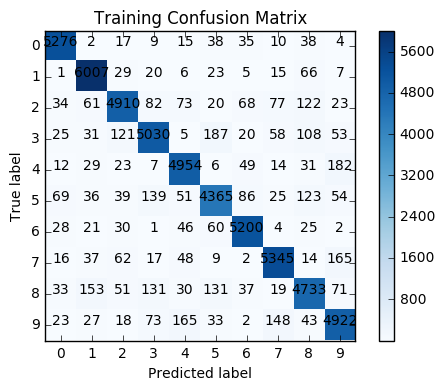

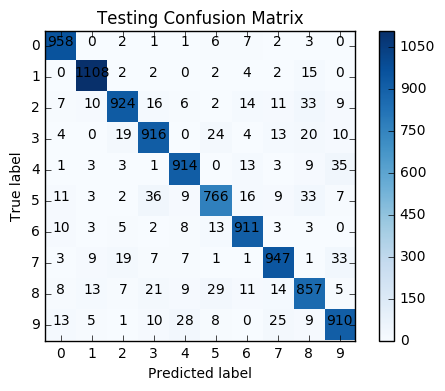

In [17]:
# build the PCA model
pca = PCA(n_components=200)
pca.fit(train_img)

train_pca = pca.transform(train_img)
test_pca = pca.transform(test_img)

# Classification using tflearn
with tf.Graph().as_default():
    tflearn.init_graph(num_cores=4, gpu_memory_fraction=0.5)

    # build the one-layer fully connected neural network
    net = tflearn.input_data(shape=[None, 200])
    net = tflearn.fully_connected(net, 10, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

    # fit the model
    model = tflearn.DNN(net)
    model.fit(train_pca, train_label)

    # predict on the training and test dataset
    train_prediction = np.array(model.predict(train_pca))
    test_prediction = np.array(model.predict(test_pca))

# get the label
train_pred_label = np.argmax(train_prediction, axis=1)
test_pred_label = np.argmax(test_prediction, axis=1)

# calculate the training and testing accuracy
train_acc = np.sum(train_pred_label == train_true_label) / len(train_true_label)
test_acc = np.sum(test_pred_label == test_true_label) / len(test_true_label)
print('Training Accuract:', str(np.round(train_acc, 5)))
print('Testing Accuract:', str(np.round(test_acc, 5)))

# calculate the confusion matrix
trainMatrix = np.dot(train_label.T, oneHotEncoder(np.array([train_pred_label]).T, 10))
testMatrix = np.dot(test_label.T, oneHotEncoder(np.array([test_pred_label]).T, 10))

# plot the training and test confusion matrix
label=[str(i) for i in range(10)]
title1 = 'Training Confusion Matrix'
fig1 = showConfusionMatrix(trainMatrix.astype(int), title=title1, label=label, fontsize=10)
fig1.savefig('./result/train_pca.pdf')
plt.show()

title2 = 'Testing Confusion Matrix'
fig2 = showConfusionMatrix(testMatrix.astype(int), title=title2, label=label, fontsize=10)
fig2.savefig('./result/test_pca.pdf')
plt.show()

# Classification using stacking RBM

In [57]:
# build the first RBM model
model = RBM(visible_nodes=784, hidden_nodes=500, learning_rate=0.1, batch_size=10, n_iter=1)
W1, b1, c1 = model.train(train_img)

# calculate the output of the first RBM on training and testing dataset
train_rbm1 = 1 / (1 + np.exp(-np.dot(train_img, W1.T) + c1))
test_rbm1 = 1 / (1 + np.exp(-np.dot(test_img, W1.T) + c1))

Reach the 1 th iteration, total time 37.83s !


In [58]:
# build the second RBM model
model = RBM(visible_nodes=500, hidden_nodes=200, learning_rate=0.1, batch_size=10, n_iter=1)
W2, b2, c2 = model.train(train_rbm1)

# calculate the output of RBM on training and testing dataset
train_rbm2 = 1 / (1 + np.exp(-np.dot(train_rbm1, W2.T) + c2))
test_rbm2 = 1 / (1 + np.exp(-np.dot(test_rbm1, W2.T) + c2))

Reach the 1 th iteration, total time 12.55s !


In [63]:
# Classification using tflearn
with tf.Graph().as_default():
    tflearn.init_graph(num_cores=4, gpu_memory_fraction=0.5)

    # build the one-layer fully connected neural network
    net = tflearn.input_data(shape=[None, 200])
    net = tflearn.fully_connected(net, 10, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

    # fit the model
    model = tflearn.DNN(net)
    model.fit(train_rbm2, train_label)

    # predict on the training and test dataset
    train_prediction = np.array(model.predict(train_rbm2))
    test_prediction = np.array(model.predict(test_rbm2))

# get the label
train_pred_label = np.argmax(train_prediction, axis=1)
test_pred_label = np.argmax(test_prediction, axis=1)

# calculate the training and testing accuracy
train_acc = np.sum(train_pred_label == train_true_label) / len(train_true_label)
test_acc = np.sum(test_pred_label == test_true_label) / len(test_true_label)
print('Training Accuract:', str(np.round(train_acc, 5)))
print('Testing Accuract:', str(np.round(test_acc, 5)))

Training Step: 8600  | total loss: 0.25880
| Adam | epoch: 010 | loss: 0.25880 -- iter: 55000/55000
Training Step: 8600  | total loss: 0.25880
| Adam | epoch: 010 | loss: 0.25880 -- iter: 55000/55000
--
Training Accuract: 0.91838
Testing Accuract: 0.9203


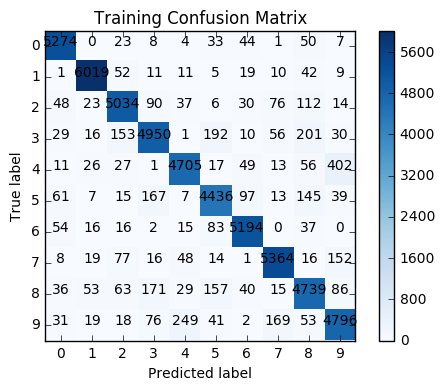

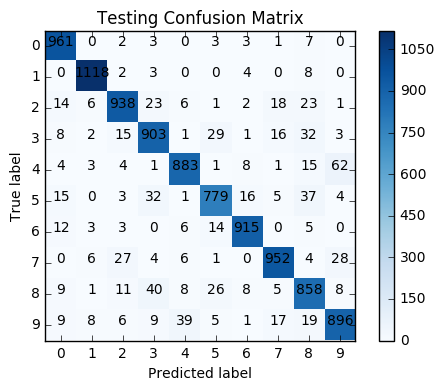

In [64]:
# calculate the confusion matrix
trainMatrix = np.dot(train_label.T, oneHotEncoder(np.array([train_pred_label]).T, 10))
testMatrix = np.dot(test_label.T, oneHotEncoder(np.array([test_pred_label]).T, 10))

# plot the training and test confusion matrix
label=[str(i) for i in range(10)]
title1 = 'Training Confusion Matrix'
fig1 = showConfusionMatrix(trainMatrix.astype(int), title=title1, label=label, fontsize=10)
fig1.savefig('./result/train_stacking.pdf')
plt.show()

title2 = 'Testing Confusion Matrix'
fig2 = showConfusionMatrix(testMatrix.astype(int), title=title2, label=label, fontsize=10)
fig2.savefig('./result/test_stacking.pdf')
plt.show()

In [ ]:
# test case, only used to determine the tuned parameters
train_acc_list = []
test_acc_list = []
for n in range(1, 11):
    # build the first RBM model
    model = RBM(visible_nodes=784, hidden_nodes=500, learning_rate=0.1, batch_size=10, n_iter=n)
    W1, b1, c1 = model.train(train_img)

    # calculate the output of the first RBM on training and testing dataset
    train_rbm1 = np.dot(train_img, W1.T) + c1
    test_rbm1 = np.dot(test_img, W1.T) + c1

    # build the second RBM model
    model = RBM(visible_nodes=500, hidden_nodes=200, learning_rate=0.1, batch_size=10, n_iter=1)
    W2, b2, c2 = model.train(train_rbm1)

    # calculate the output of RBM on training and testing dataset
    train_rbm2 = np.dot(train_rbm1, W2.T) + c2
    test_rbm2 = np.dot(test_rbm1, W2.T) + c2

    # Classification using tflearn
    with tf.Graph().as_default():
        tflearn.init_graph(num_cores=6, gpu_memory_fraction=0.8)

        # build the one-layer fully connected neural network
        net = tflearn.input_data(shape=[None, 200])
        net = tflearn.fully_connected(net, 10, activation='softmax')
        net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

        # fit the model
        model = tflearn.DNN(net)
        model.fit(train_rbm2, train_label)

        # predict on the training and test dataset
        train_prediction = np.array(model.predict(train_rbm2))
        test_prediction = np.array(model.predict(test_rbm2))

    # get the label
    train_pred_label = np.argmax(train_prediction, axis=1)
    test_pred_label = np.argmax(test_prediction, axis=1)

    # calculate the training and testing accuracy
    train_acc = np.sum(train_pred_label == train_true_label) / len(train_true_label)
    test_acc = np.sum(test_pred_label == test_true_label) / len(test_true_label)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
# plot the train and test accuracy
fig, ax = plt.subplots()
ax.plot(train_acc_list, 'g.-')
ax.plot(test_acc_list, 'r.-')
plt.show()